In [1]:
from pathlib import Path

## Protein Embeddings Manipulation

In [2]:
from proteins import EmbeddingProtein1D, AttrDict

### Utility Functions

In [3]:
from utils import open_func, load_dataset

data_path = Path('data')
open_func(data_path, 'stability')['train']

labels                                     sequence
0       0.37  GSSQETIEVEDEEEARRVAKELRKKGYEVKDERRGNKWHVHRT
1       0.62  TLDEARELVERAKKEGTGMDVNGQRFEDWREAERWVREQEKNK
2      -0.03  TELKKKLEEALKKGEEVRVKFNGIEIRNTSEDAARKAVELLEK
3       1.41  GSSQETIEVEDEEEARRVAKELRKTGYEVKIERRGNKWHVHRT
4       1.11  TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLQVTIKNGKITVT
...      ...                                          ...
7705    0.80  GSSKTQYEYDTKEEHQKAYEKFKKQGIPVTITQKNGKWFVQVE
7706    0.82  TIDEIIKALEQAVKDNKPIQVGNYTVTSADEAEKLAKKLKKPY
7707    0.66  TQDEIIKALEQAVKDNKPIQVGNYTVTSADEAEKLAKKLKKEY
7708    1.05  TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVWVTR
7709    1.69  GSSTTWYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR

[7710 rows x 2 columns]

In [4]:
# args_dict = {
#     'model_name': 'esm1b_t33_650M_UR50S',
#     'open_func': open_func,
#     'data_path': data_path,
#     'gpu': True
# }

# emb_stabilty = EmbeddingProtein1D(**args_dict)

# _ = emb_stabilty.generate_embeddings('stability', kind='test', save=True, bs=256)
# embeddings = emb_stabilty.generate_embeddings('stability', save=True, bs=256)

## Dimensionality Reduction

In [5]:
import torch; torch.cuda.is_available()

True

Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master


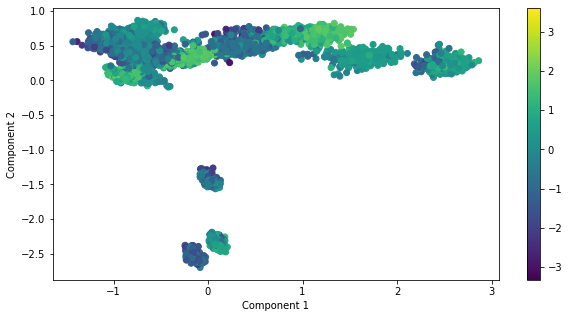

In [6]:
import matplotlib.pyplot as plt
import cuml

from utils import dim_reduction

X_train, y_train, dset = load_dataset(data_path, kind = 'train', reduce = True, to_torch = False, close_h5 = True)
_ = dim_reduction(X_train, y_train, plot_viz=True)

In [7]:
from models import perform_search

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

scoring = "r2"
score = r2_score
models = {
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(100,), (100,100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

for name, model in models.items():
    perform_search(X_train, y_train, model["model"], model["params"], name)

Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.4s finished
/opt/miniconda3/envs/protera-rapids/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR best R2: 0.44854147492805063
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting model MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 14.7min finished
/opt/miniconda3/envs/protera-rapids/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLP best R2: 0.6126556774474677
Best params: {'activation': 'relu', 'hidden_layer_sizes': (1024, 1024), 'solver': 'adam'}


In [11]:
model = MLPRegressor(**{
    'activation': 'relu', 
    'hidden_layer_sizes': (1024, 1024), 
    'solver': 'adam', 
    'learning_rate':'adaptive',
    
})

X_train, y_train, dset = load_dataset(data_path, kind = 'train', reduce = True, to_torch = False, close_h5 = True)
X_test, y_test, dset = load_dataset(data_path, kind = 'test', reduce = True, to_torch = False, close_h5 = True)

model.fit(X_train, y_train.ravel())
model.score(X_test, y_test.ravel())

Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master
Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master


-1.3038908253477315

## Can a FeedForward Net do better?


In [4]:
from torch import nn
import torch.nn.functional as F

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 1024, act = None, drop_p = 0.7, last_drop = False):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units//2)
        self.fc3 = nn.Linear(n_units//2, 1)
        
        self.drop = nn.Dropout(p=drop_p)
        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.LeakyReLU()
            
    def forward(self, x):
        out = self.act(self.drop(self.fc1(x)))
        out = self.act(self.drop(self.fc2(out)))
        out = self.fc3(out)
        
        if self.last_drop: 
            out = self.drop(out)
        return self.act(out)

In [5]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="batch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    max_epochs=int(1e4),
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda',
    callbacks=[cb, sched, stopper],
    module__n_units=1024
)

X_train, y_train = load_dataset(data_path, kind = 'train', reduce = False, to_torch = True, close_h5 = True)
X_test, y_test = load_dataset(data_path, kind = 'test', reduce = False, to_torch = True, close_h5 = True)

net.fit(X_train, y_train)

Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master
Returning existing dataset...
Using cache found in /home/step/.cache/torch/hub/facebookresearch_esm_master
Returning existing dataset...


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.7505        0.5961     +  0.4050
      2        0.6504        0.6095        0.0792
      3        0.6327        0.5683     +  0.0781
      4        0.6260        0.5588     +  0.0787
      5        0.6106        0.5592        0.0800
      6        0.6066        0.5511     +  0.0785
      7        0.6049        0.5482     +  0.0790
      8        0.6004        0.5412     +  0.0782
      9        0.5855        0.5248     +  0.0782
     10        0.5683        0.5141     +  0.0770
     11        0.5622        0.5141     +  0.0778
     12        0.5585        0.5064     +  0.0790
     13        0.5557        0.5225        0.0781
     14        0.5498        0.4815     +  0.0778
     15        0.5158        0.4497     +  0.0777
     16        0.4863        0.4054     +  0.0764
     17        0.4450        0.3924     +  0.0788
     18        0.4180        0.3512     +  0.0774


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ProteinMLP(
    (fc1): Linear(in_features=1280, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=1, bias=True)
    (drop): Dropout(p=0.7, inplace=False)
    (act): LeakyReLU(negative_slope=0.01)
  ),
)

In [6]:
net.score(X_test, y_test)

0.7753543013812965